# SwissMetNet Station data for Downscaling Project

Hourly Data of observed near-surface wind speed at 54 stations from the automatic monitoring network of MeteoSwiss, the SwissMetNet.
Data is available from [IDAweb](https://www.meteoswiss.admin.ch/home/services-and-publications/beratung-und-service/datenportal-fuer-lehre-und-forschung.html)  

Stations are selected based on [Graf et al., 2019](https://doi.org/10.1002/joc.6108).


In [1]:
# =======
# import packages
import pandas as pd
import numpy as np
from zipfile import ZipFile
import glob

In [2]:
# location of smn files
datapath = '../data/swissmetnet/'

# print files
for zip_file in glob.glob(datapath + '*.zip'):
    print(zip_file)

# read files and concatenate to one single dataframe
df = [pd.read_csv(ZipFile(zip_file).open(f), sep=";", skiprows=range(0, 3), header=None, names=['station', 'time', 'gust', 'windspeed', 'direction'], converters={'time': str}) 
    for zip_file in glob.glob(datapath + '*.zip')
    for f in ZipFile(zip_file).namelist() 
    if f.endswith("data.txt")]
df = pd.concat(df,ignore_index=True, axis=0)
df = df[~df.station.str.contains("stn")] # remove rows containing header names 

../data/swissmetnet/order94714_wind_swiss_plateau.zip
../data/swissmetnet/order94706_wind_alpine_valley.zip
../data/swissmetnet/order94717_wind_swiss_plateau_zh.zip
../data/swissmetnet/order94707_wind_jura.zip
../data/swissmetnet/order94705_wind_alps.zip
../data/swissmetnet/order94716_wind_ticino.zip
../data/swissmetnet/order94704_wind_alpine_preak.zip


/home/steidani/miniconda3/envs/firedanger/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (2,3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
# save as csv containing all stations
compression_opts = dict(method='zip', archive_name='smn_stations_2016_2020.csv')  
df.to_csv(datapath + 'smn_stations_2016_2020.zip', sep=';', index=False, compression=compression_opts) 

In [3]:
# =======
# do some quality checks

# number of stations
df.station.unique()
len(df.station.unique())
# why not 54 like in Graf et al., 2019? Station Davos (DOV) did not have windspeed data...

# length of each station
df['station'].value_counts(dropna=False)
# all have same length of 43872. 

# check for missing values
df.isna().sum()
df[df == '-'].sum(axis=0) # Missing values are marked with '-'

# check occurence of specific time steps
df['time'].value_counts(ascending=True, dropna=False)
# looks good: all stations have same time period from 2016010100 to 2021010123 

2017020918    53
2016121315    53
2019061419    53
2020070406    53
2016121721    53
              ..
2018071715    53
2020120816    53
2020081305    53
2018070214    53
2020092500    53
Name: time, Length: 43872, dtype: int64

# EXTRA
## A beautiful plot using shaded relief from swisstopo

Download shaded relief from swisstopo from here: https://shop.swisstopo.admin.ch/en/products/maps/overview/relief

In [4]:
# =======
# import packages
import numpy as np
import xarray as xr
from cartopy.io.img_tiles import GoogleTiles
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

import logging
logger = logging.getLogger(__name__)
#logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)

# for plotting
try:
    from affine import Affine
    from rasterio.warp import transform
except:
    logger.warning("Rasterio is not installed in your python environment. You cannot read GEOTIFF Swisstopo data.")

In [5]:
# read relief and data
da = xr.open_rasterio('../data/dtm/relief_georef_clipped_swiss.tif')
# Compute the lon/lat coordinates with rasterio.warp.transform
ny, nx = len(da['y']), len(da['x'])
x, y = np.meshgrid(da['x'], da['y'])
# Rasterio works with 1D arrays
lon, lat = transform(da.crs, {'init': 'EPSG:4326'},
                     x.flatten(), y.flatten())
lon = np.asarray(lon).reshape((ny, nx))-0.01
lat = np.asarray(lat).reshape((ny, nx))
da.coords['lon'] = (('y', 'x'), lon)
da.coords['lat'] = (('y', 'x'), lat)

# get data
greyscale = da.mean(dim='band')
greyscale = greyscale.where(greyscale > 1, drop=True)

# define colormay
cmap = plt.cm.Greys_r #or any other colormap
normalize = colors.Normalize(vmin=155, vmax=253)

In [6]:
# get SwissMetNet Stations into
df=pd.read_csv(datapath + 'smn_station_info.txt', sep=',')
df.head()


,abbreviation,station,sensor altitude [m asl],Longitude/Latitude,Coordinates [km]
0,***Alpine mountain peaks***,NaN,NaN,NaN,NaN
1,GUE,Gütsch ob Andermatt,2342.0,8°37'/46°39',690050/167475
2,JUN,Jungfraujoch,3571.0,7°59'/46°33',641938/155287
3,PIL,Pilatus,2105.0,8°15'/46°59',661903/203410
4,COV,Piz Corvatsch,3294.0,9°49'/46°25',783154/143524


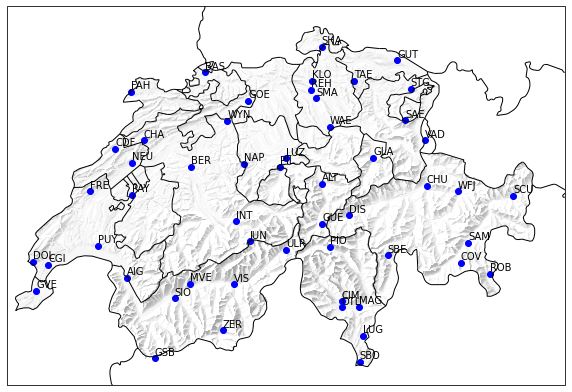

In [10]:
plt.figure(figsize=(10, 10))

ax = plt.axes(projection=ccrs.AlbersEqualArea(8.222665776, 46.800663464))
ax.set_extent([5.9, 10.7, 45.7, 47.9])
greyscale.plot(ax=ax, x='lon', y='lat', cmap="Greys_r", norm=normalize, add_colorbar=False, transform=ccrs.PlateCarree())

# plot station
def dms_to_dd(d, m):
    dd = int(d) + int(m)/60
    return dd

for index, row in df.iterrows():
    if np.isnan(row['sensor altitude [m asl]']):
        continue
    # plot location
    ax.scatter(dms_to_dd(row['Longitude/Latitude'][-13:-11],row['Longitude/Latitude'][-10:-8]), 
               dms_to_dd(row['Longitude/Latitude'][-6:-4],row['Longitude/Latitude'][-3:-1]),
               color='blue', marker='o', transform=ccrs.Geodetic())
    # plot name of station
    ax.text(dms_to_dd(row['Longitude/Latitude'][-13:-11],row['Longitude/Latitude'][-10:-8]), 
             dms_to_dd(row['Longitude/Latitude'][-6:-4],row['Longitude/Latitude'][-3:-1])+0.02,
             row['abbreviation'],
             horizontalalignment='left',
             transform=ccrs.Geodetic())
    
# add country border
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1)
# add cantons
import cartopy.io.shapereader as shapereader
provinces = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_1_states_provinces_lines')
for country in shapereader.Reader(provinces).records():
    if country.attributes['adm0_name'] == 'Switzerland':
        swiss = country.geometry
        ax.add_geometries([swiss], ccrs.PlateCarree(), edgecolor='black', facecolor='none')

# save figure
plt.savefig('smn_station_relief.png', dpi=200)